In [1]:
from dataclasses import dataclass
import torch
from torch.utils.data import Dataset
import numpy as np
import cv2
from PIL import Image, ImageDraw, ImageFont
import torchvision.transforms as transforms
from scipy.ndimage import map_coordinates, gaussian_filter

import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torch.utils.data import DataLoader, Dataset

<>:142: SyntaxWarning: invalid escape sequence '\O'
<>:142: SyntaxWarning: invalid escape sequence '\O'
C:\Users\zfaye\AppData\Local\Temp\ipykernel_40088\3527181890.py:142: SyntaxWarning: invalid escape sequence '\O'
  dataset = SyntheticPlayerNumberDataset(num_samples=1000, font_path="fonts\Oswald\static\Oswald-SemiBold.ttf", transform=transform)


Label: 50


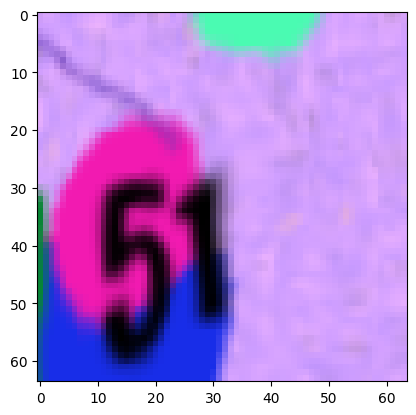

In [ ]:
# 自定义 Dataset 类
@dataclass
class SyntheticPlayerNumberDataset(Dataset):
    num_samples: int
    font_path: str
    transform: transforms.Compose = None
    img_size: int = 64

    def __len__(self):
        return self.num_samples

    # 工具函数：生成Perlin噪声
    def generate_perlin_noise(self, size, scale=10):
        lin = np.linspace(0, scale, size, endpoint=False)
        x, y = np.meshgrid(lin, lin)
        random_gradients = np.random.rand(size, size, 2) * 2 - 1
        x_grad, y_grad = random_gradients[..., 0], random_gradients[..., 1]
        perlin_noise = x_grad * np.cos(2 * np.pi * x) + y_grad * np.sin(2 * np.pi * y)
        return (perlin_noise - perlin_noise.min()) / (perlin_noise.max() - perlin_noise.min())

    # 工具函数：随机透视变换
    def random_perspective(self, img, max_warp=0.2):
        h, w = img.shape[:2]
        src = np.float32([[0, 0], [w, 0], [0, h], [w, h]])
        dst = src + np.random.uniform(-max_warp * w, max_warp * w, src.shape).astype(np.float32)
        M = cv2.getPerspectiveTransform(src, dst)
        img = cv2.warpPerspective(img, M, (w, h), borderMode=cv2.BORDER_REPLICATE)
        return img

    # 工具函数：随机裁切
    def random_crop(self, img, crop_ratio=0.2):
        h, w = img.shape[:2]
        crop_h, crop_w = int(crop_ratio * h), int(crop_ratio * w)
        top, left = np.random.randint(0, crop_h + 1), np.random.randint(0, crop_w + 1)
        bottom, right = h - np.random.randint(0, crop_h + 1), w - np.random.randint(0, crop_w + 1)
        img = img[top:bottom, left:right]
        img = cv2.resize(img, (w, h))
        return img

    # 工具函数：随机扭曲
    def random_distort(self, img, alpha=20, sigma=5):
        shape = img.shape
        dx = gaussian_filter(np.random.randn(*shape[:2]), sigma) * alpha
        dy = gaussian_filter(np.random.randn(*shape[:2]), sigma) * alpha
        x, y = np.meshgrid(np.arange(shape[1]), np.arange(shape[0]))
        indices = np.reshape(y + dy, (-1, 1)), np.reshape(x + dx, (-1, 1))
        distorted_img = np.zeros_like(img)
        for i in range(shape[2]):
            distorted_img[..., i] = map_coordinates(img[..., i], indices, order=1, mode='reflect').reshape(shape[:2])
        return distorted_img

    # 工具函数：随机添加图形
    def random_add_shapes(self, img, num_shapes=5):
        h, w = img.shape[:2]
        shapes = ['rectangle', 'circle', 'line']
        colors = [tuple(np.random.randint(0, 256, size=3).tolist()) for _ in range(num_shapes)]
        
        for _ in range(num_shapes):
            shape = np.random.choice(shapes)
            color = colors.pop()
            
            if shape == 'rectangle':
                pt1 = (np.random.randint(0, w), np.random.randint(0, h))
                pt2 = (np.random.randint(0, w), np.random.randint(0, h))
                cv2.rectangle(img, pt1, pt2, color, -1)
            
            elif shape == 'circle':
                center = (np.random.randint(0, w), np.random.randint(0, h))
                radius = np.random.randint(5, min(h, w) // 4)
                cv2.circle(img, center, radius, color, -1)
            
            elif shape == 'line':
                pt1 = (np.random.randint(0, w), np.random.randint(0, h))
                pt2 = (np.random.randint(0, w), np.random.randint(0, h))
                thickness = np.random.randint(1, 5)
                cv2.line(img, pt1, pt2, color, thickness)

        return img

    def pick_number(self):
        all_nums = np.arange(1, 100)
        prob = np.ones_like(all_nums)
        prob[:51] = 4
        prob[:25] = 8
        prob = prob / prob.sum()
        return np.random.choice(all_nums, p=prob)

    def __getitem__(self, idx):
        # 随机生成球员编号
        number = self.pick_number()
        label = number

        # 生成背景
        bg_color = np.random.randint(50, 200, size=3)  # 主色调
        background = np.ones((self.img_size, self.img_size, 3), dtype=np.uint8) * bg_color
        perlin = self.generate_perlin_noise(self.img_size, scale=np.random.randint(10, 80))
        background = background + (perlin[..., None] * np.random.randint(50, 300, size=3)).astype(np.uint8)
        background = np.clip(background, 0, 255).astype(np.uint8)

        if np.random.rand() < 0.3:
            background = self.random_add_shapes(background)

        # 绘制数字
        pil_img = Image.fromarray(background)
        draw = ImageDraw.Draw(pil_img)

        text = f"{number}"
        try:
            font = ImageFont.truetype(self.font_path, size=np.random.randint(16, 44))
        except:
            font = ImageFont.load_default()
            print("Font not found, using default font.")

        text_color = tuple(np.random.randint(256, size=3))
        if np.random.rand() < 0.3:
            text_color = (0, 0, 0)
        if np.random.rand() < 0.3:
            text_color = (255, 255, 255)
        
        text_w, text_h = draw.textbbox((0, 0), text, font=font)[2:]
        pos = ((self.img_size - text_w) // 2, (self.img_size - text_h) // 2)
        draw.text(pos, text, fill=text_color, font=font)

        # 转为 OpenCV 格式并应用随机变形
        img = np.array(pil_img)
        img = self.random_perspective(img)
        img = self.random_distort(img)
        img = self.random_crop(img)

        # 转换为张量
        if self.transform:
            img = self.transform(img)
        return img, label - 1

<>:8: SyntaxWarning: invalid escape sequence '\O'
<>:8: SyntaxWarning: invalid escape sequence '\O'
C:\Users\zfaye\AppData\Local\Temp\ipykernel_40088\3448266201.py:8: SyntaxWarning: invalid escape sequence '\O'
  dataset = SyntheticPlayerNumberDataset(num_samples=1000, font_path="fonts\Oswald\static\Oswald-SemiBold.ttf", transform=transform)


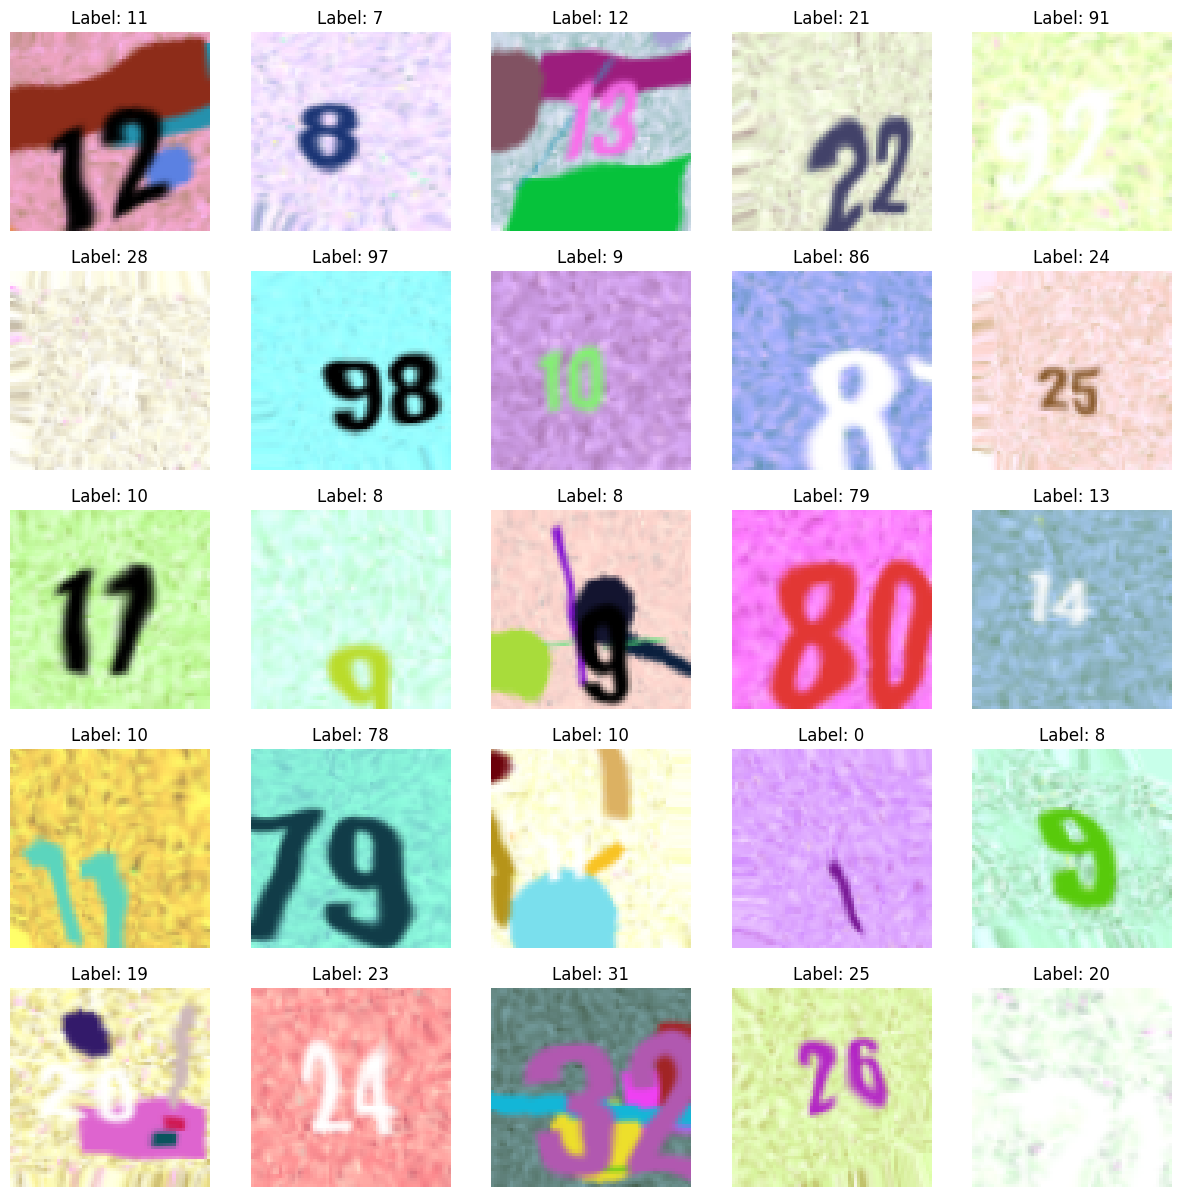

In [59]:
# 数据增强与预处理
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# 使用示例
dataset = SyntheticPlayerNumberDataset(num_samples=1000, font_path="fonts\Oswald\static\Oswald-SemiBold.ttf", transform=transform)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=128, shuffle=True)

# Sample images from dataset
sample_loader = DataLoader(dataset, batch_size=25, shuffle=True)
images, labels = next(iter(sample_loader))

# Plot images with labels
fig, axes = plt.subplots(5, 5, figsize=(15, 15))
axes = axes.ravel()
for i, ax in enumerate(axes):
    img = images[i].cpu().permute(1, 2, 0).numpy() * 0.5 + 0.5  # 反归一化
    ax.imshow(img)
    ax.set_title(f"Label: {labels[i].item()}")
    ax.axis('off')
plt.show()

In [ ]:
# 自定义的小型 ResNet 网络
class SmallResNet(nn.Module):
    def __init__(self, fc=512, num_classes=99):
        super(SmallResNet, self).__init__()
        # 使用 torchvision.models 提供的 ResNet18，并对其做一些调整
        self.backbone = torchvision.models.resnet18(weights=None)  # 不加载预训练权重
        self.backbone.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.backbone.maxpool = nn.Identity()  # 删除最大池化层以适配小输入
        self.backbone.fc = nn.Linear(fc, num_classes)  # 修改最后全连接层的输出
        
    def forward(self, x):
        return self.backbone(x)


# 训练代码
def train(model, dataloader, criterion, optimizer, epochs=10):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        correct = 0
        total = 0
        for images, labels in dataloader:
            images, labels = images.cuda(), labels.long().cuda()
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
        
        print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss/len(dataloader):.4f}, Accuracy: {100*correct/total:.2f}%")

In [ ]:
import wandb
from tqdm.auto import tqdm

model = SmallResNet(fc=1024, num_classes=99).cuda()

def main(model, epochs=10, lr=0.001):

    wandb.init(
        # set the wandb project where this run will be logged
        project="ScoccerNet-JerseyNumber",

        # track hyperparameters and run metadata
        config={
            "learning_rate": lr,
            "architecture": "ResNet",
            "dataset": "Generated",
            "epochs": epochs,
        }
    )

    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    # 开始训练
    model.train()
    for epoch in tqdm(range(epochs)):
        total_loss = 0
        correct = 0
        total = 0
        for images, labels in dataloader:
            images, labels = images.cuda(), labels.long().cuda()
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
        
        wandb.log({"loss": total_loss/len(dataloader), "accuracy": 100*correct/total})
    
    wandb.finish()

    if input("Save model? (y/n): ").lower() == "y":
        torch.save(model.state_dict(), "resnet.pt")

main(model, epochs=200, lr=0.002)

  0%|          | 0/200 [00:00<?, ?it/s]

accuracy,▁▁▁▁▁▁▁▁▁▁▃▃▆▇▇▇▇▇▇▇▇███████████████████
loss,███▇▇▇▇▇▇▇▇▇▇▇▇▄▄▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
accuracy,94.7
loss,0.20053


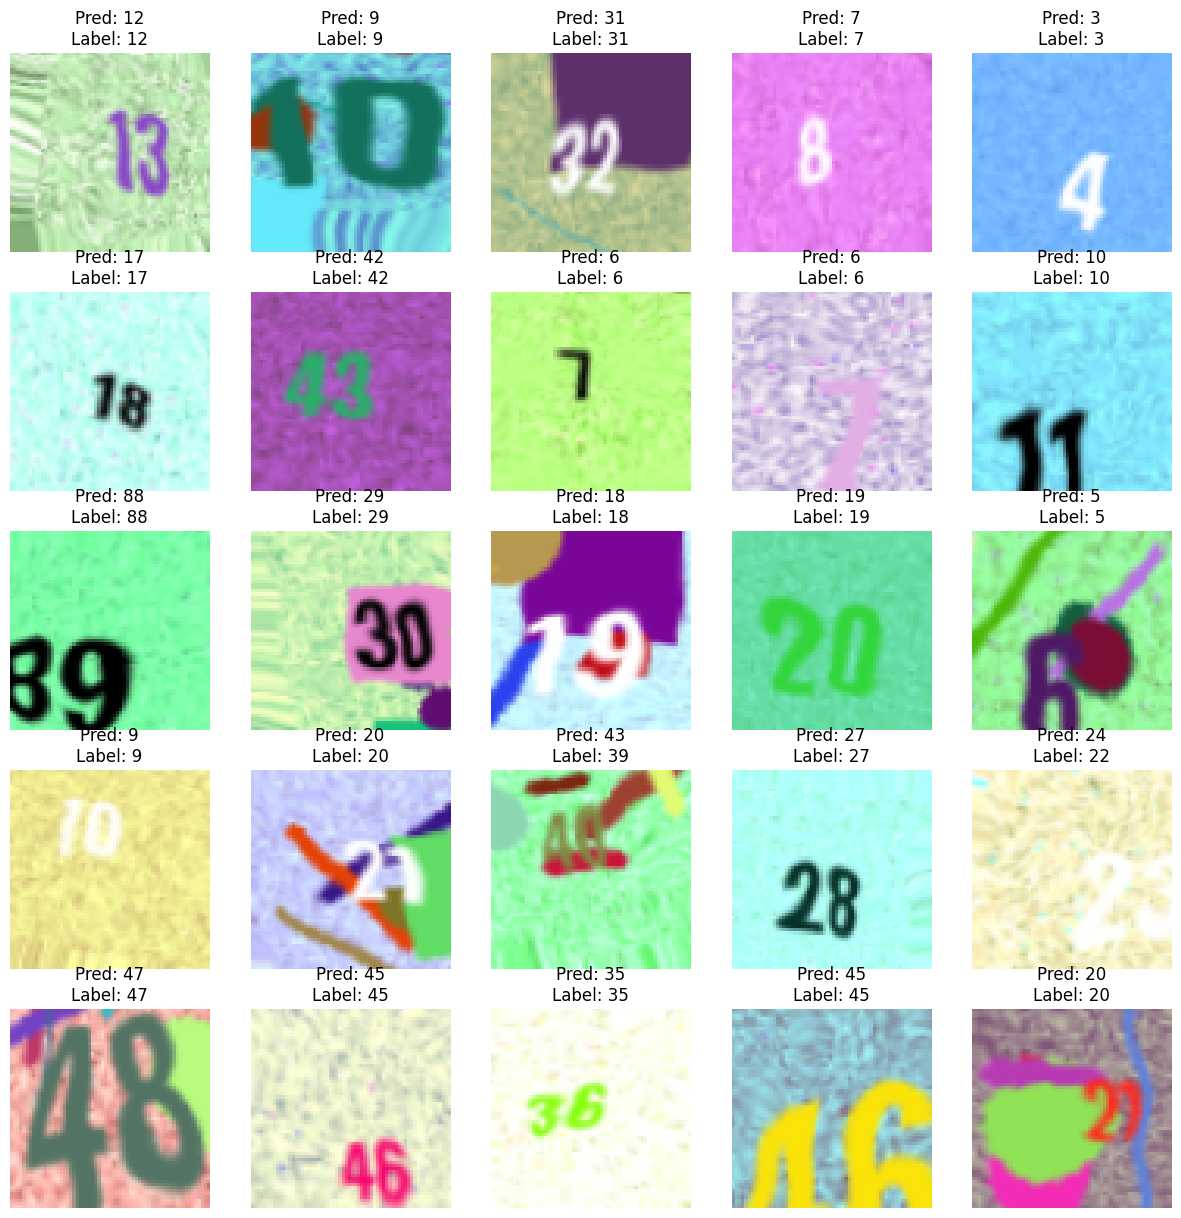

In [64]:
model.eval()
# Sample images from dataset
sample_loader = DataLoader(dataset, batch_size=25, shuffle=True)
images, labels = next(iter(sample_loader))

# Move images to GPU
images = images.cuda()

# Get model predictions
model.eval()
with torch.no_grad():
    outputs = model(images)
    _, predicted = outputs.max(1)

# Plot images with predictions
fig, axes = plt.subplots(5, 5, figsize=(15, 15))
axes = axes.ravel()
for i, ax in enumerate(axes):
    img = images[i].cpu().permute(1, 2, 0).numpy() * 0.5 + 0.5  # 反归一化
    ax.imshow(img)
    ax.set_title(f"Pred: {predicted[i].item()}\nLabel: {labels[i].item()}")
    ax.axis('off')
plt.show()

C:\Users\zfaye\AppData\Local\Temp\ipykernel_40088\1615932391.py:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("resnet.pt"))


  0%|          | 0/1427 [00:00<?, ?it/s]

C:\Users\zfaye\AppData\Local\Temp\ipykernel_40088\1615932391.py:55: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


Label: 10, 	Predicted (mode): 9, 	Predicted (max): 9
Label: 30, 	Predicted (mode): 6, 	Predicted (max): 16
Label: 27, 	Predicted (mode): 20, 	Predicted (max): 26
Label: 10, 	Predicted (mode): 6, 	Predicted (max): 13
Label: 75, 	Predicted (mode): 12, 	Predicted (max): 13
Label: 8, 	Predicted (mode): 6, 	Predicted (max): 6
Label: 4, 	Predicted (mode): 6, 	Predicted (max): 16
Label: 14, 	Predicted (mode): 0, 	Predicted (max): 6
Label: 3, 	Predicted (mode): 6, 	Predicted (max): 6
Label: 25, 	Predicted (mode): 6, 	Predicted (max): 0
Label: 8, 	Predicted (mode): 6, 	Predicted (max): 6
Label: 24, 	Predicted (mode): 13, 	Predicted (max): 13
Label: 4, 	Predicted (mode): 6, 	Predicted (max): 16
Label: 50, 	Predicted (mode): 3, 	Predicted (max): 6
Label: 4, 	Predicted (mode): 6, 	Predicted (max): 3
Label: 10, 	Predicted (mode): 6, 	Predicted (max): 6
Label: 27, 	Predicted (mode): 6, 	Predicted (max): 3
Label: 44, 	Predicted (mode): 6, 	Predicted (max): 23
Label: 4, 	Predicted (mode): 6, 	Predicte

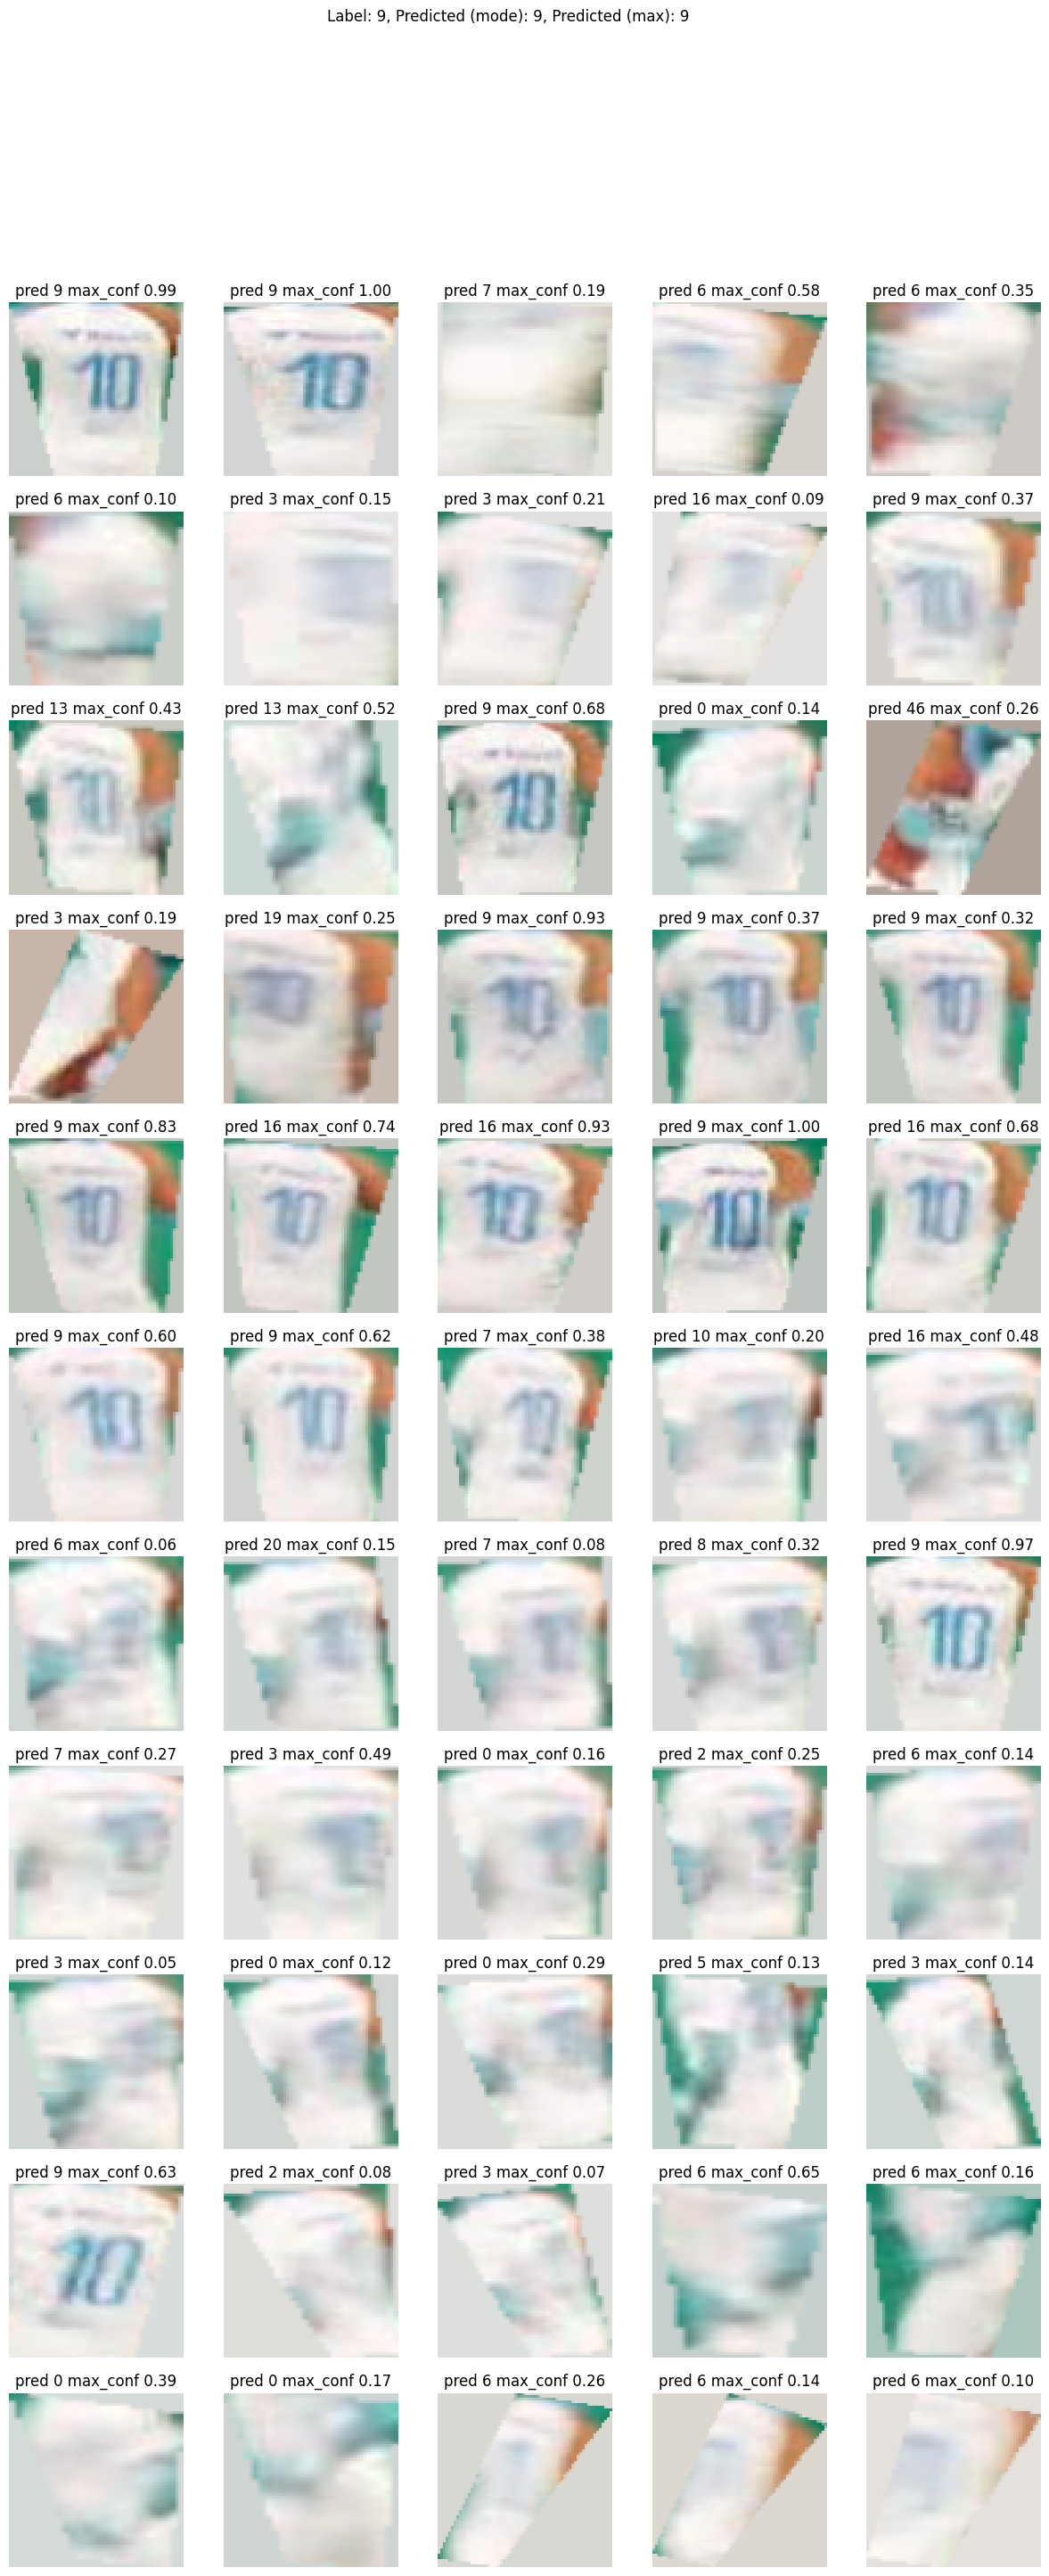

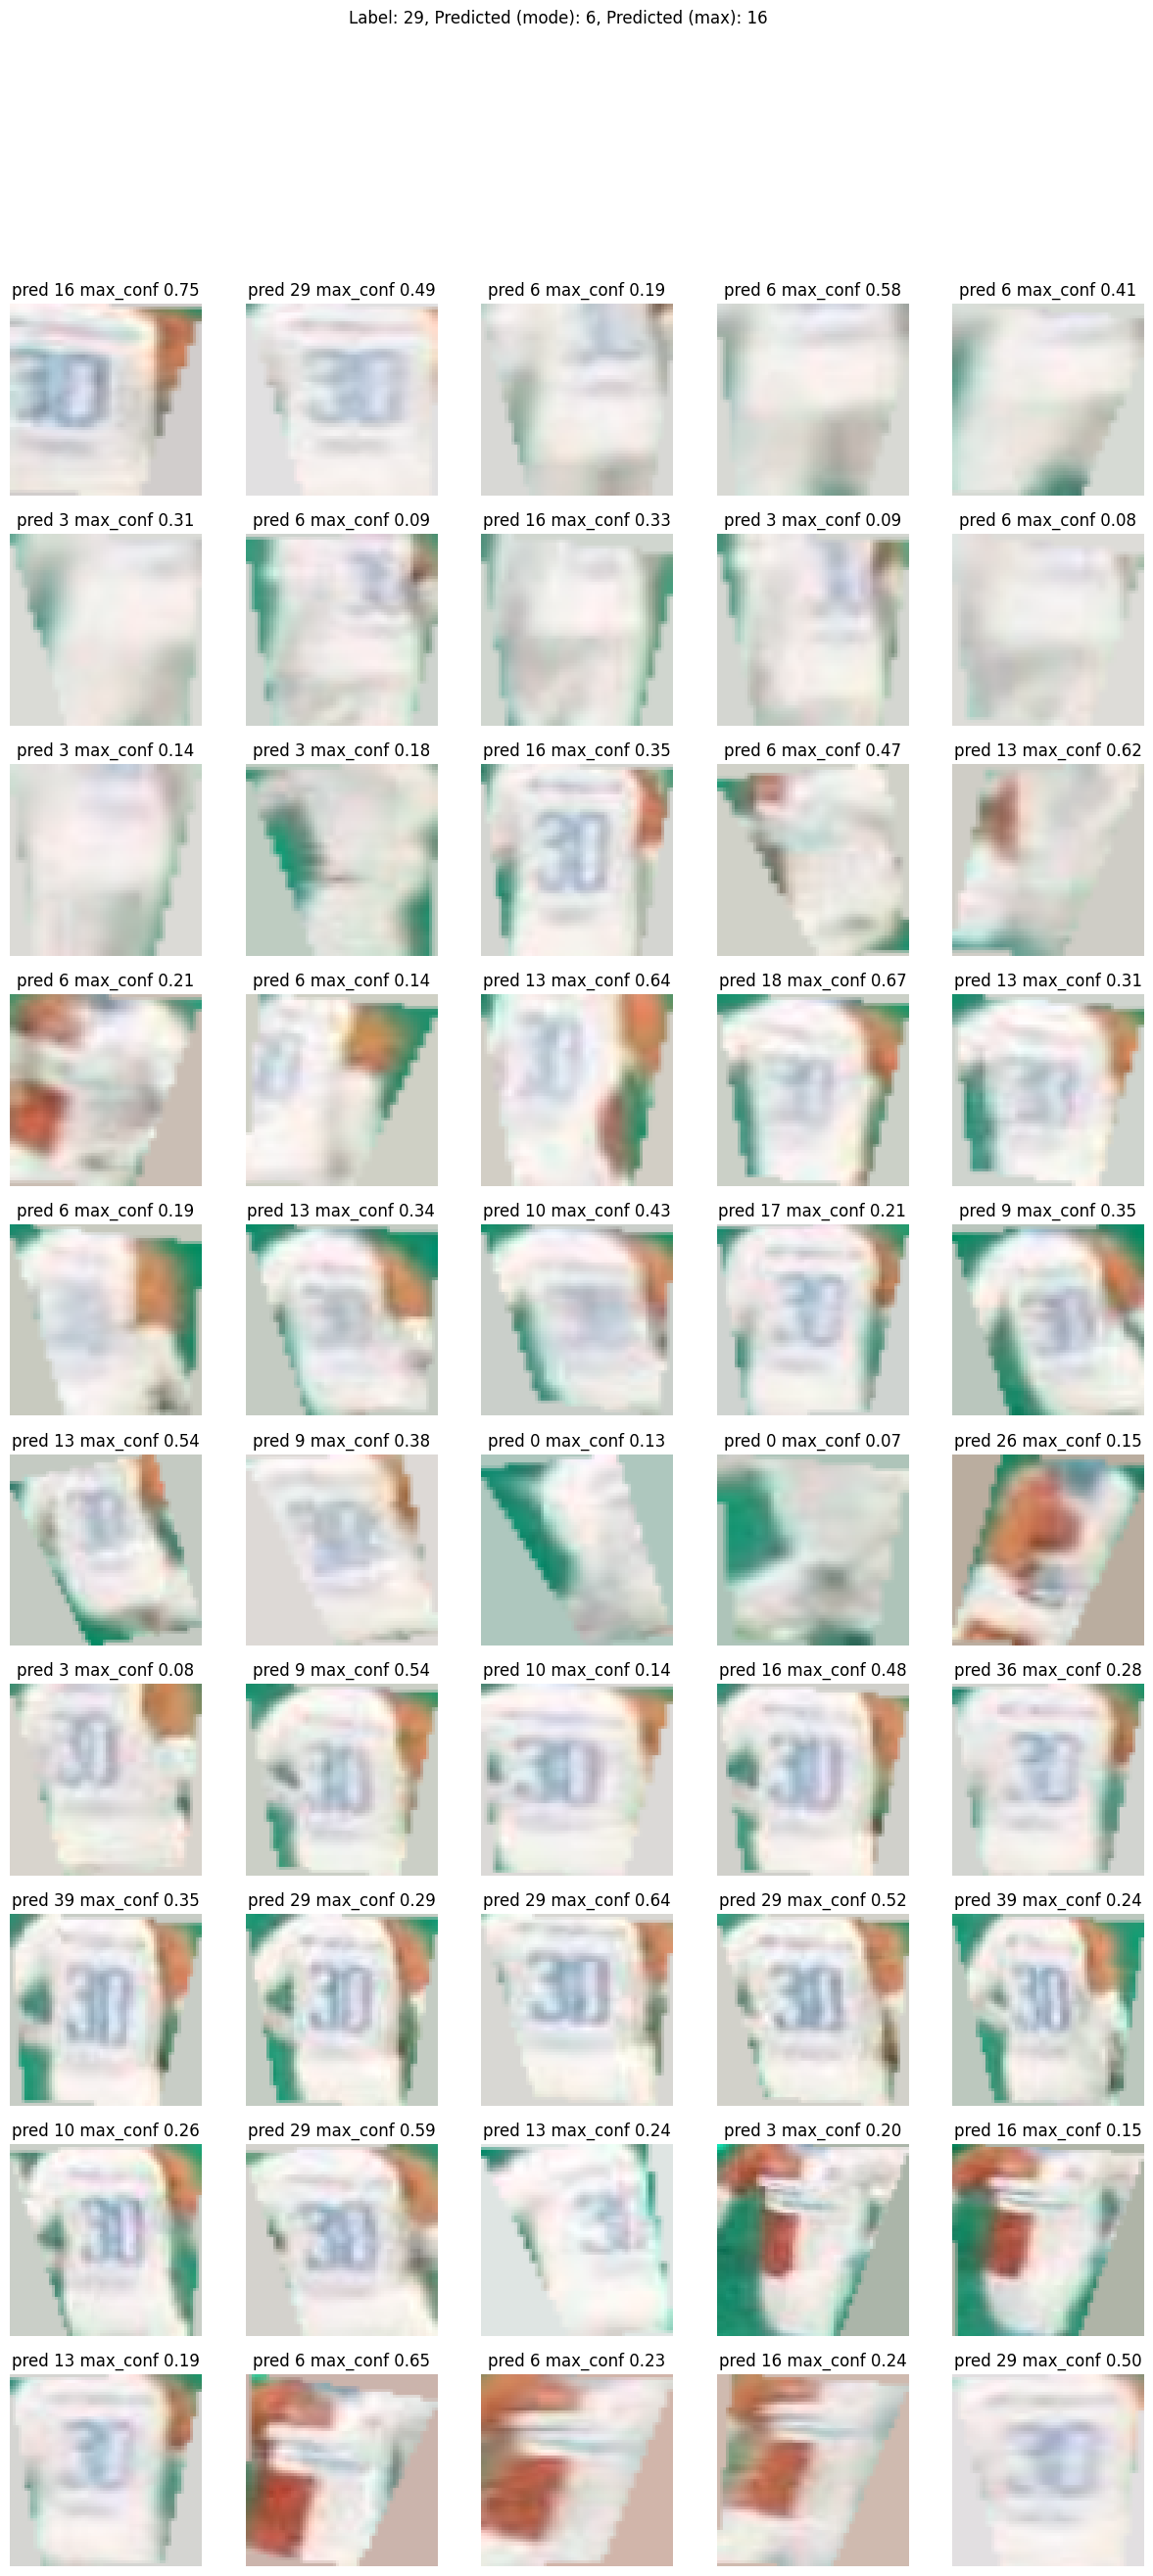

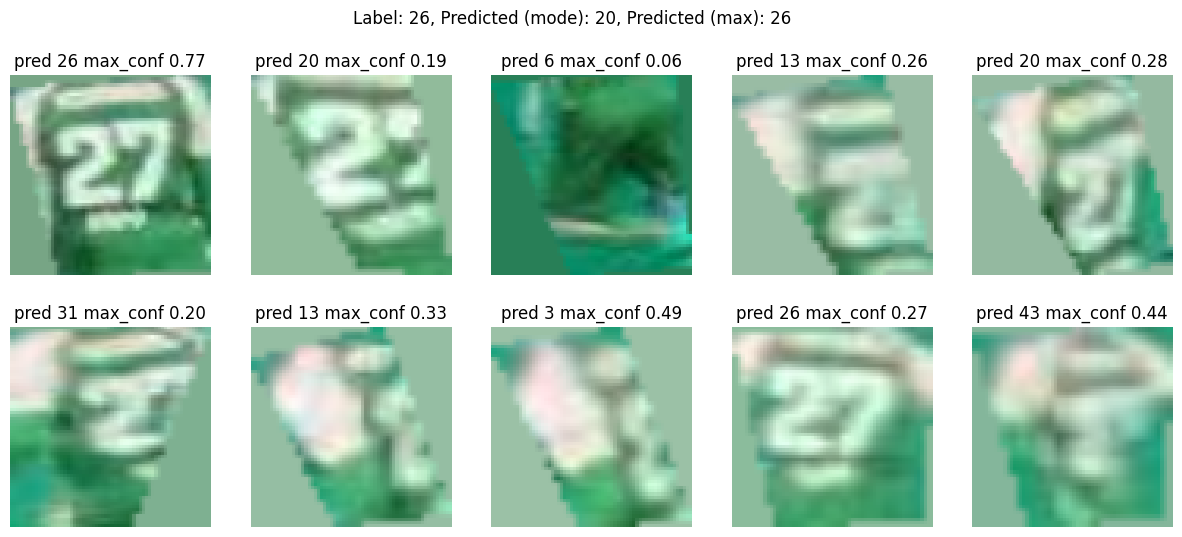

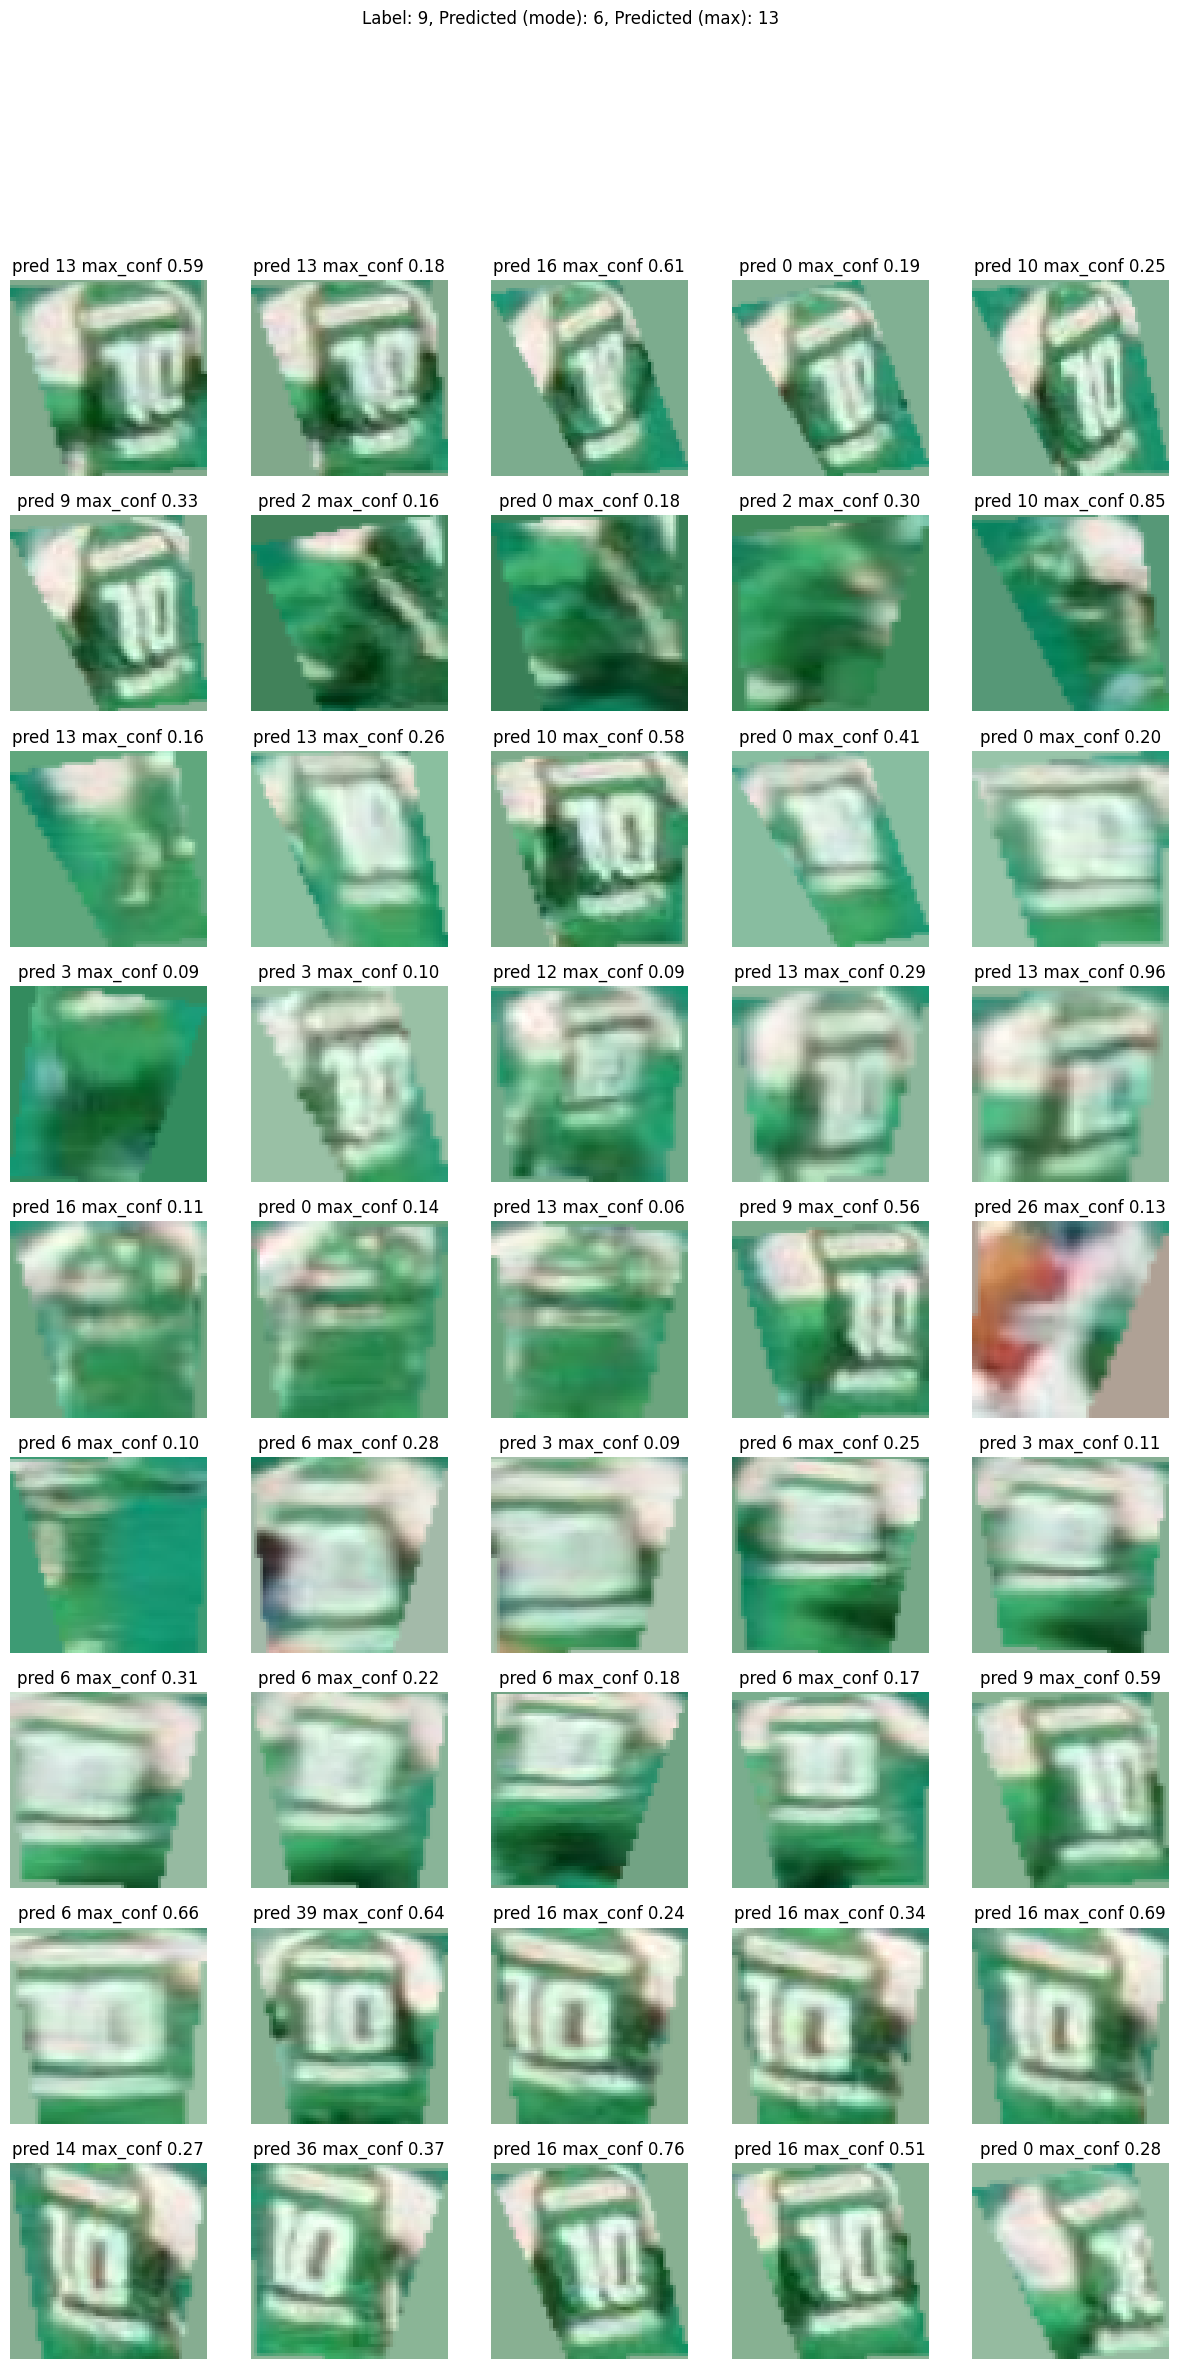

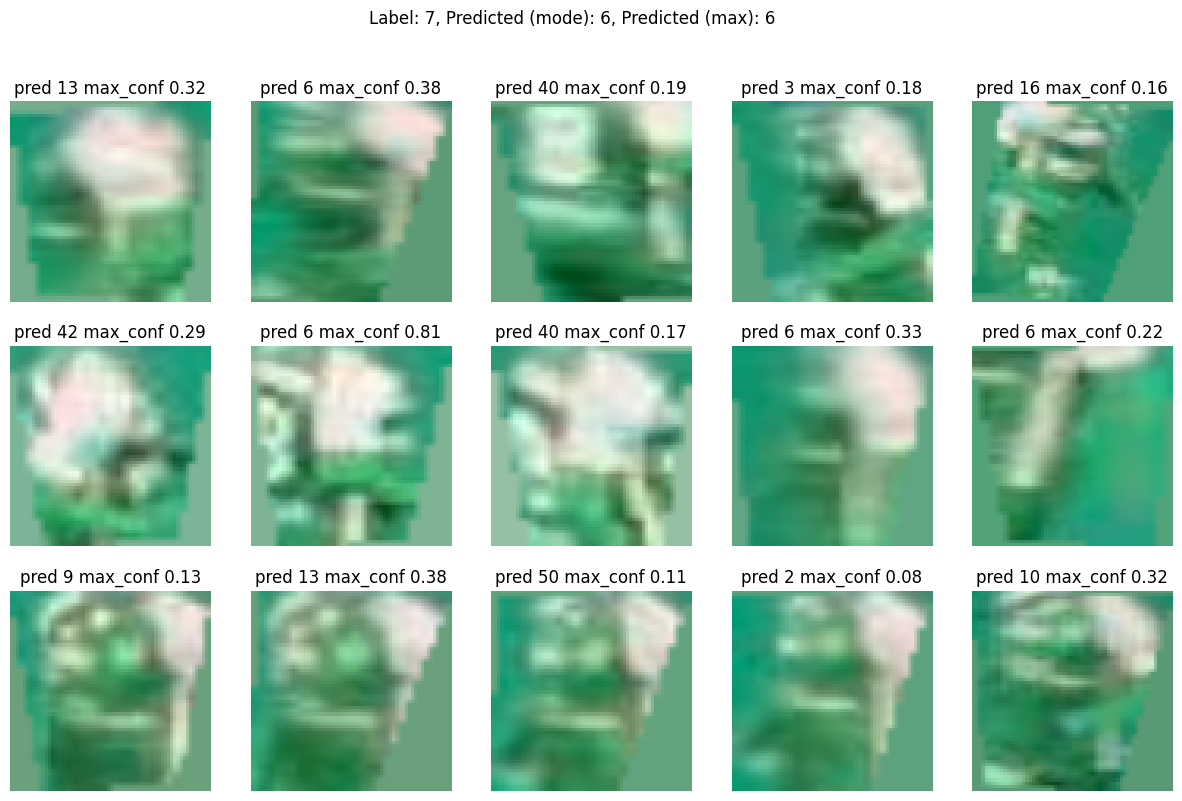

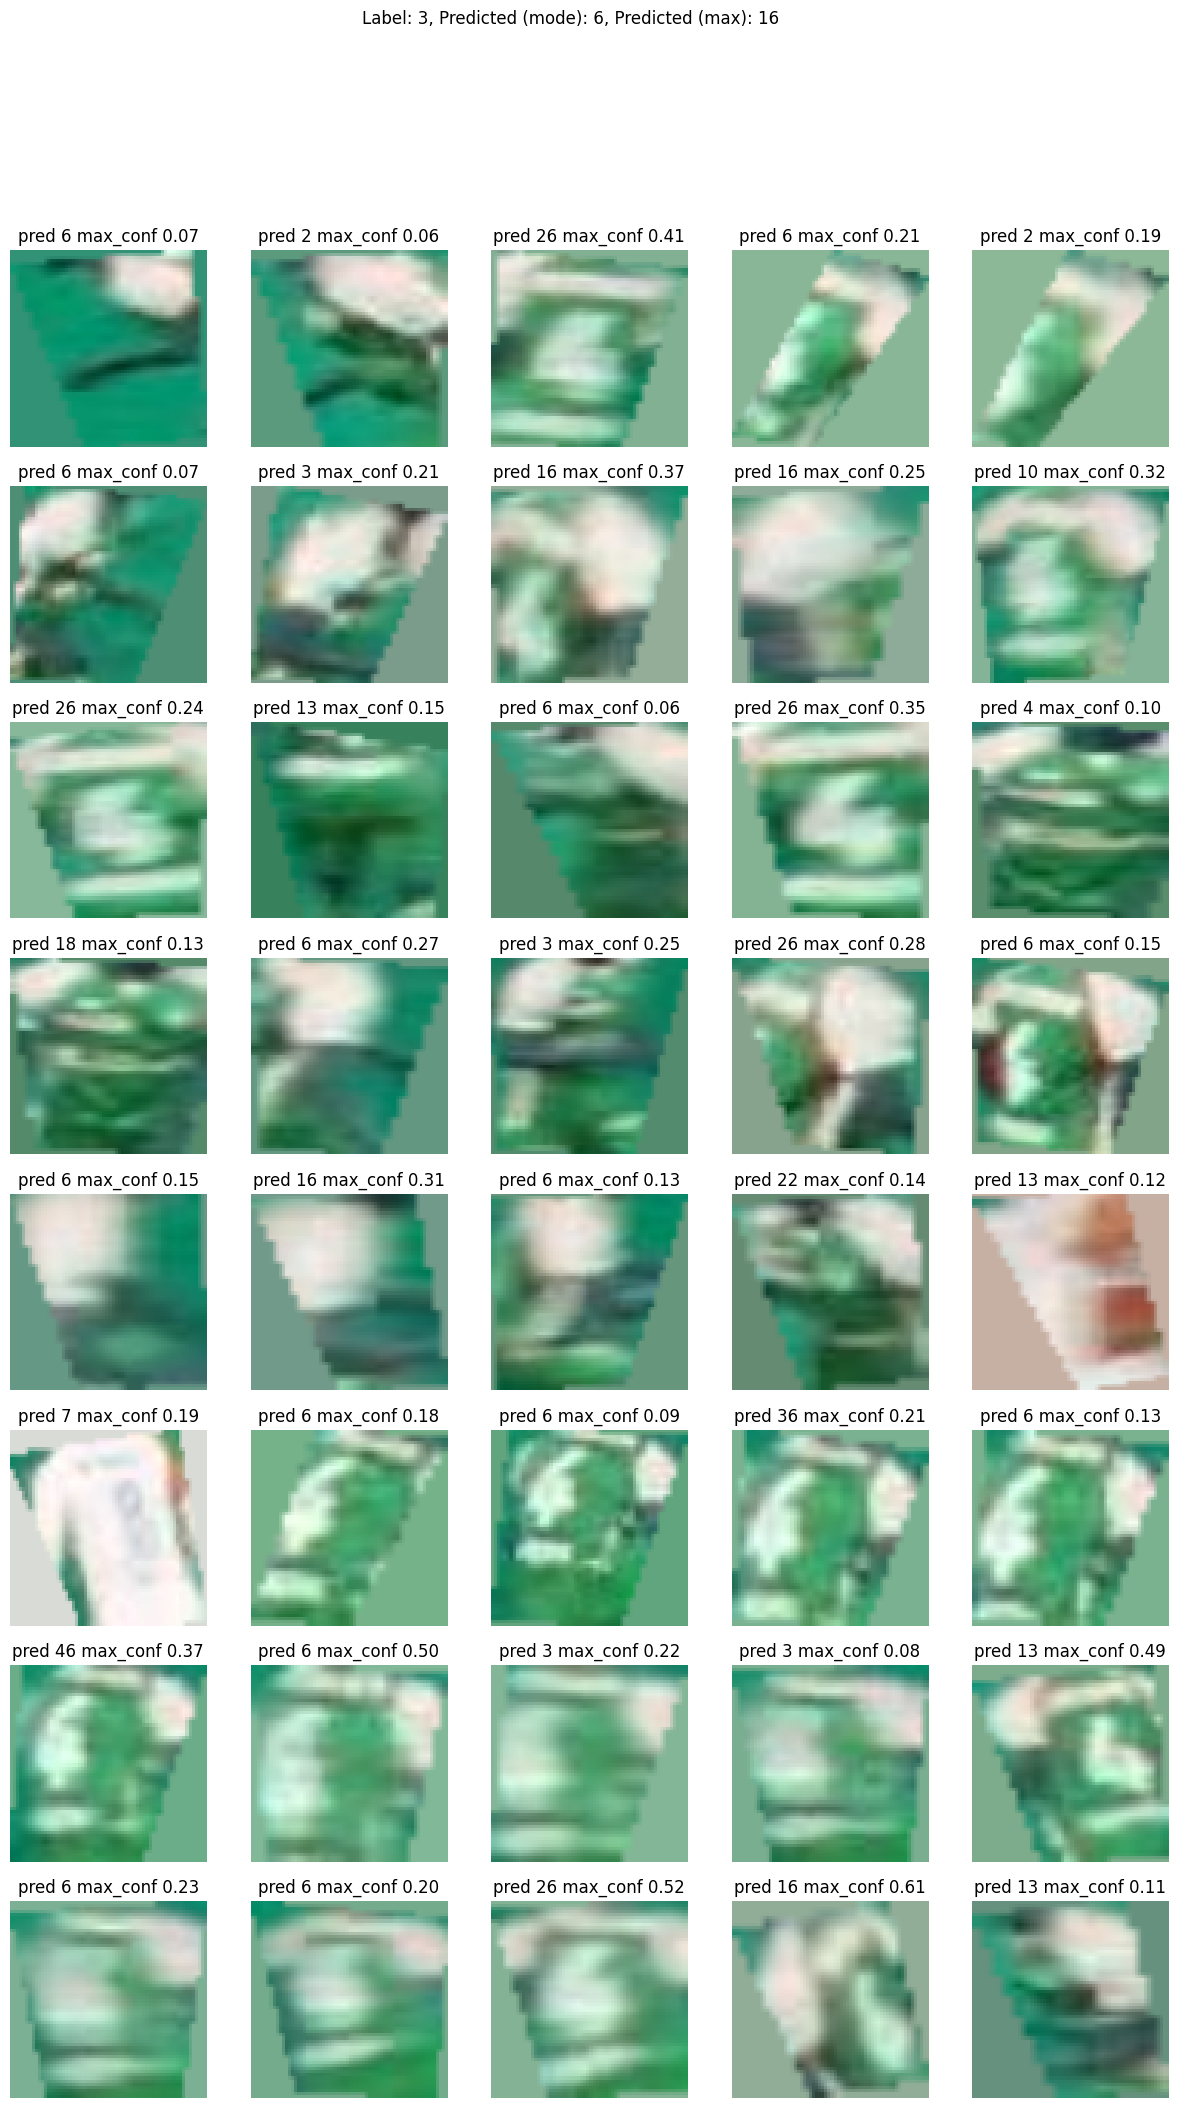

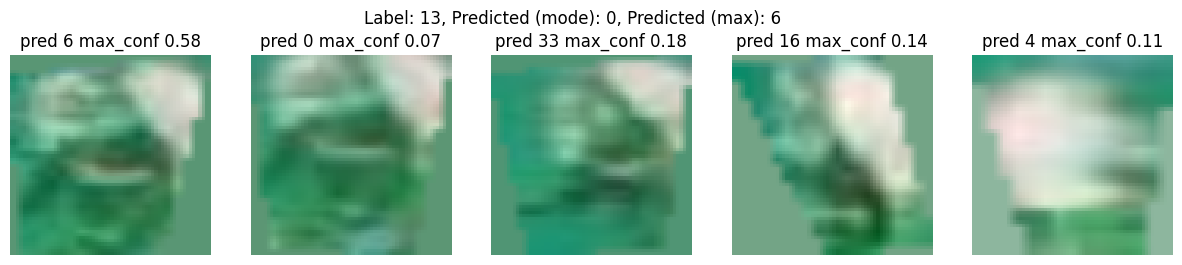

In [95]:
root = r'crops\train'
label_path = r'SoccerNet\jersey-2023\train\train_gt.json'

import json
import os
import cv2

with open(label_path, 'r') as f:
    labels = json.load(f)


total = 0
model = SmallResNet(num_classes=99).cuda()
model.load_state_dict(torch.load("resnet.pt"))
model.eval()

hit_mode = hit_max = 0

for i, (no, label) in enumerate(tqdm(labels.items())):
    if label == -1:
        continue
    img_path = os.path.join(root, no)
    images = []
    if not os.path.exists(img_path):
        continue
    for img_file in os.listdir(img_path):
        img = cv2.imread(os.path.join(img_path, img_file))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (64, 64))
        img = transform(img)
        images.append(img)
    if len(images) == 0:
        continue
    images = torch.stack(images).cuda()
    with torch.no_grad():
        outputs = model(images)
        probs = F.softmax(outputs, dim=1)
        confidence, predicted = probs.max(1)
        final_pred_mode = predicted.mode().values.item()
        final_pred_max = predicted[confidence.argmax()].item()

    if len(images) >= 5 and i < 10:
        m = 5
        n = int(len(images) / m)
        fig, axes = plt.subplots(n, m, figsize=(15, 3*n))
        axes = axes.ravel()
        for i, ax in enumerate(axes):
            if i < len(images):
                img = images[i].cpu().permute(1, 2, 0).numpy() * 0.5 + 0.5
                ax.imshow(img)
                ax.set_title(f"pred {predicted[i].item()} max_conf {confidence[i].item():.2f}")
                ax.axis('off')
        fig.suptitle(f"Label: {label-1}, Predicted (mode): {final_pred_mode}, Predicted (max): {final_pred_max}")
        # fig.tight_layout()
        fig.show()

    total += 1
    hit_mode += final_pred_mode == label - 1
    hit_max += final_pred_max == label - 1
    print(f"Label: {label}, \tPredicted (mode): {final_pred_mode}, \tPredicted (max): {final_pred_max}")
    
print(f"Accuracy (mode): {100*hit_mode/total:.2f}%")
print(f"Accuracy (max): {100*hit_max/total:.2f}%")